In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

sys.path.append(Path().resolve())
sys.path.append(os.path.join(Path().resolve(), 'DigiLeTs/scripts'))

In [2]:
from data import read_original_data

In [3]:
from env import DrawingEnv_Moc1

In [4]:
def fill_traj(target_position, initial_position, norm, z_pos=0):
    positions = [initial_position]
    d_pos = target_position[:2] - positions[-1][:2]
    while np.linalg.norm(d_pos) > norm:
        pos = positions[-1][:2] + (d_pos / np.linalg.norm(d_pos) * norm)
        positions.append(np.hstack([pos, z_pos]))
        d_pos = target_position[:2] - positions[-1][:2]
    return positions

def get_trajectory(instance, initial_position):
    # initial_position = np.array([0.8, 0.2, 0])
    norm = np.linalg.norm(instance[1:,:2]-instance[:-1,:2], axis=-1)
    norm_mean = norm[norm>0].mean()
    trajectory = fill_traj(target_position=instance[0], initial_position=initial_position, norm=norm_mean)
    
    for i in range(0, len(instance) - 1):
        if (instance[i][5] == 0 and instance[i+1][5] == 0) and (instance[i+1][3] == 0):
            position = [np.array((instance[i+1][0], instance[i+1][1], 1))]
        else:
            position = fill_traj(target_position=instance[i+1], initial_position=trajectory[-1], norm=norm_mean)
        trajectory += position

    trajectory += fill_traj(target_position=initial_position, initial_position=trajectory[-1], norm=norm_mean)
    trajectory = np.array(trajectory)
    return trajectory

In [5]:
import cv2
import copy

def get_image_sequence(instance, size=256, line_width=3, threshold=None):
    initial_position=np.array((0.8, 0.8, 0))
    params = dict(size=256,
                line_color=(50,50,50),
                line_width=3,
                digit_area = [30,36,158,164],
                initial_position=initial_position,
                max_step=2e2,
                )
    instance[:,1] = 1-instance[:,1]
    trajectory = get_trajectory(instance=instance, initial_position=initial_position)
    
    
    env = DrawingEnv_Moc1(params)
    observation = env.init()
    images = [observation["image"]]
    mask = [observation["mask"]]
    actions = []
    positions = [observation["position"]]
    for t in range(0, len(trajectory) - 1):
        observation, reward, done, info = env.step(trajectory[t])
        images.append(observation["image"])
        positions.append(observation["position"])
        mask.append(observation["mask"])
        action = trajectory[t+1][:2]-trajectory[t][:2]
        actions.append(action)

    images = np.array(images).astype(np.uint8)
    mask = np.array(mask).astype(np.uint8)
    positions = np.array(positions)
    observations = dict(image=images,mask=mask,position=positions)
    actions = np.array(actions)
    rewards = np.zeros(len(actions))
    dones = np.zeros(len(actions))
    dones[-1] = 1
    return observations, actions, rewards, dones


In [6]:
import glob
data_dir = "DigiLeTs/data/preprocessed/complete"
filenames = glob.glob(os.path.join(data_dir, '*_preprocessed'))

In [7]:
import os
for idx in range(len(filenames)):
    filename = filenames[idx]
    basename = os.path.basename(filename)
    participant = read_original_data(filename)
    if idx < 70:
        save_folder = "dataset/Drawing/realistic/train"
    else:
        save_folder = "dataset/Drawing/realistic/validation"
    for s, symbol in enumerate(participant["trajectories"]):
        if s > 9:
            # 数字以外は省略
            break
        for i, _instance in enumerate(symbol):
            
            instance = _instance[:participant["lengths"][s, i]]
            observations, actions, rewards, dones = get_image_sequence(instance, size=64, line_width=3)
            dataset = dict()
            dataset["image"] = observations["image"]
            dataset["mask"] = observations["mask"]
            dataset["position"] = observations["position"]
            dataset["action"] = actions
            dataset["reward"] = rewards
            dataset["done"] = dones
            
        break
    break
            # save_foldername = "{}/{}".format(save_folder, s)
            # save_filename = "{}/{}_{}.npy".format(save_foldername, basename, i)
            # # print(save_filename)
            # os.makedirs(save_foldername, exist_ok=True)
            # np.save(save_filename, dataset)

Reading from: DigiLeTs/data/preprocessed/complete/002-f-22-right_2019-06-05-12-21-29_preprocessed


In [19]:
show_plot = False

if show_plot:
    for i in range(3):
        plt.plot(observations["position"][:,i])
    plt.show()

In [20]:
position = observations["position"]
d_pos = position[1:,:2] - position[:-1,:2]


if show_plot:
    for i in range(2):
        plt.plot(d_pos[:,i])
    plt.show()

In [21]:
norm_body = np.linalg.norm(d_pos, axis=-1)

if show_plot:
    plt.plot(norm_body)
    plt.show()

In [22]:
import copy
norm_digit = copy.deepcopy(norm_body)
norm_digit[position[1:,2]==0] = 0

if show_plot:
    plt.plot(norm_digit)
    plt.show()

In [23]:
total_norm_body = [0]
total_norm_digit = [0]
for t in range(len(norm_body)):
    total_norm_body.append(norm_body[:t].sum())
    total_norm_digit.append(norm_digit[:t].sum())
    
if show_plot:
    plt.plot(total_norm_body, label="body")
    plt.plot(total_norm_digit, label="digit")
    plt.legend()
    plt.show()

In [25]:
tau_norm_body = total_norm_body/total_norm_body[-1]
tau_norm_digit = total_norm_digit/total_norm_digit[-1]

if show_plot:
    plt.plot(tau_norm_body, label="body")
    plt.plot(tau_norm_digit, label="digit")
    plt.legend()
    plt.show()

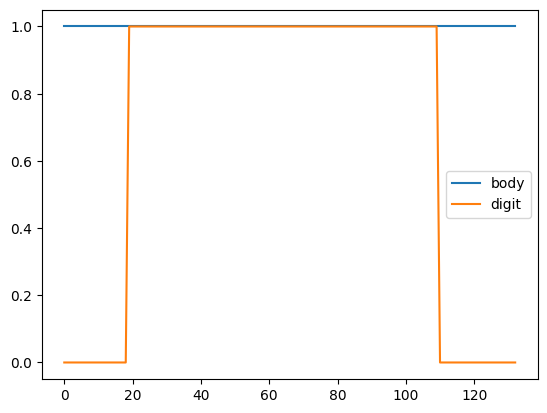

In [29]:
timestep_body = np.ones(len(norm_body))
timestep_digit = np.ones(len(norm_digit))
timestep_digit[position[1:,2]==0] = 0

plt.plot(timestep_body, label="body")
plt.plot(timestep_digit, label="digit")
plt.legend()
plt.show()

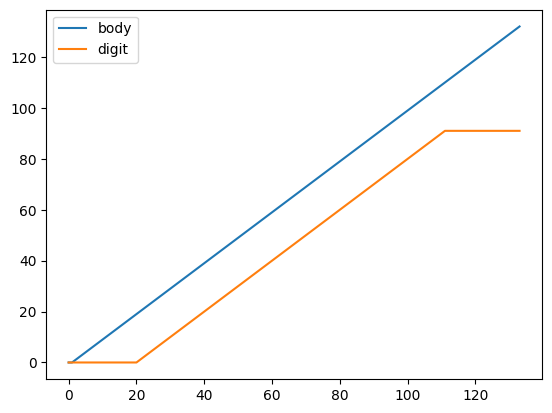

In [30]:
total_timestep_body = [0]
total_timestep_digit = [0]
for t in range(len(timestep_body)):
    total_timestep_body.append(timestep_body[:t].sum())
    total_timestep_digit.append(timestep_digit[:t].sum())

plt.plot(total_timestep_body, label="body")
plt.plot(total_timestep_digit, label="digit")
plt.legend()
plt.show()

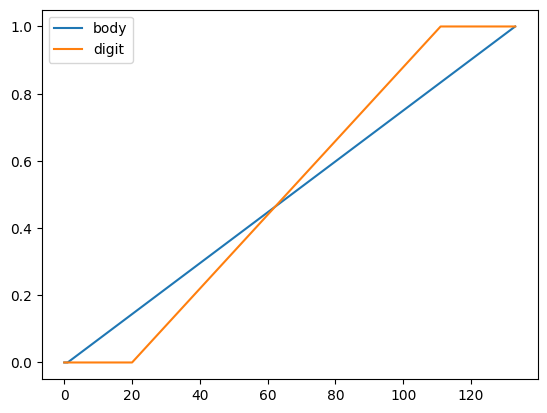

In [31]:
tau_time_body = total_timestep_body/total_timestep_body[-1]
tau_time_digit = total_timestep_digit/total_timestep_digit[-1]

plt.plot(tau_time_body, label="body")
plt.plot(tau_time_digit, label="digit")
plt.legend()
plt.show()

position: (134, 3)
tau_norm_body: (134,)
tau_norm_digit: (134,)
tau_time_body: (134,)
tau_time_digit: (134,)


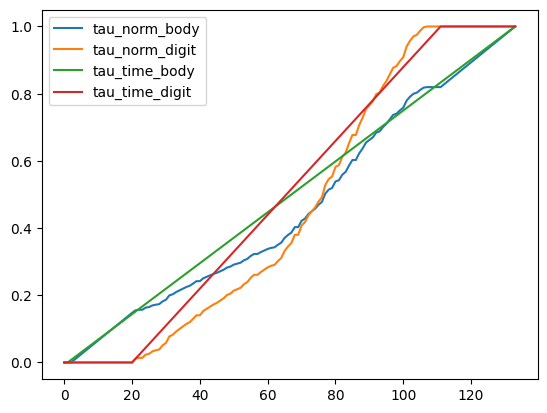

In [34]:
print(f"position: {position.shape}")
print(f"tau_norm_body: {tau_norm_body.shape}")
print(f"tau_norm_digit: {tau_norm_digit.shape}")
print(f"tau_time_body: {tau_time_body.shape}")
print(f"tau_time_digit: {tau_time_digit.shape}")

plt.plot(tau_norm_body, label="tau_norm_body")
plt.plot(tau_norm_digit, label="tau_norm_digit")
plt.plot(tau_time_body, label="tau_time_body")
plt.plot(tau_time_digit, label="tau_time_digit")
plt.legend()
plt.show()

In [46]:
import copy
position = observations["position"]

def get_tau(position):
    d_pos = position[1:,:2] - position[:-1,:2]
    norm_body = np.linalg.norm(d_pos, axis=-1)
    norm_digit = copy.deepcopy(norm_body)
    norm_digit[position[1:,2]==0] = 0
    total_norm_body = [0]
    total_norm_digit = [0]
    for t in range(len(norm_body)):
        total_norm_body.append(norm_body[:t].sum())
        total_norm_digit.append(norm_digit[:t].sum())
    tau_norm_body = total_norm_body/total_norm_body[-1]
    tau_norm_digit = total_norm_digit/total_norm_digit[-1]

    timestep_body = np.ones(len(norm_body))
    timestep_digit = np.ones(len(norm_digit))
    timestep_digit[position[1:,2]==0] = 0
    total_timestep_body = [0]
    total_timestep_digit = [0]
    for t in range(len(timestep_body)):
        total_timestep_body.append(timestep_body[:t].sum())
        total_timestep_digit.append(timestep_digit[:t].sum())
    tau_time_body = total_timestep_body/total_timestep_body[-1]
    tau_time_digit = total_timestep_digit/total_timestep_digit[-1]
    tau = dict(tau_norm_body=np.expand_dims(tau_norm_body, -1),
               tau_norm_digit=np.expand_dims(tau_norm_digit, -1),
               tau_time_body=np.expand_dims(tau_time_body, -1),
               tau_time_digit=np.expand_dims(tau_time_digit, -1),
               )
    return tau

In [47]:
tau = get_tau(observations["position"])

In [48]:

tau.keys()

dict_keys(['tau_norm_body', 'tau_norm_digit', 'tau_time_body', 'tau_time_digit'])

In [49]:
for key in tau.keys():
    print(f"{key}: {tau[key].shape}")

tau_norm_body: (134, 1)
tau_norm_digit: (134, 1)
tau_time_body: (134, 1)
tau_time_digit: (134, 1)


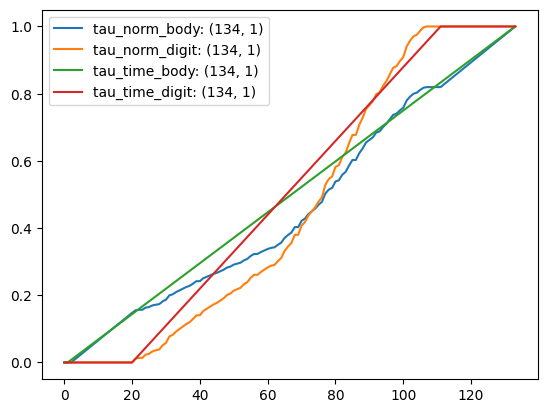

In [50]:
for key in tau.keys():
    plt.plot(tau[key], label=f"{key}: {tau[key].shape}")
plt.legend()
plt.show()